## Homework 3, Grant McKercher, October 27, 2015

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from coordinateSystems import RadarCoordinateSystem

In [2]:
# reading data file
import netCDF4 as nc
filename = 'cfrad.20080604_002217_000_SPOL_v36_SUR.nc'

f = nc.Dataset(filename, 'r')

r = f.variables['range'][:]
az = f.variables['azimuth'][:]
el = f.variables['elevation'][:]
dBZ = f.variables['DBZ'][:]
swp = f.variables['sweep_start_ray_index'][:]

## Number 1

### PPI

In [3]:
print 'These are the indecies of the sweeps', swp

These are the indecies of the sweeps [   0  483  966 1448 1931 2412 2894 3376 3860]


normal el, az, r shape: (4343,) (4343,) (996,)
sliced el, az, r shape: (483,) (483,) (996,)
Meshgrids shape: (996, 483) (996, 483) (996, 483)
ECEF flattened shape: (481068,) (481068,) (481068,)
updated shape to match: (996, 483) (996, 483) (996, 483)
normal dBz shape: (4343, 996)
updated dBz shape: (996, 483)


<matplotlib.colorbar.Colorbar instance at 0x114661128>

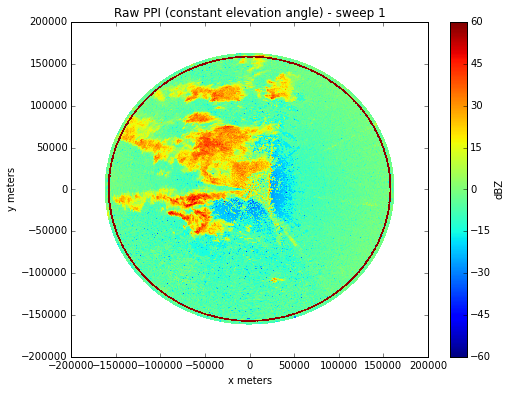

In [4]:
# slicing for the first sweep
print 'normal el, az, r shape:', el.shape, az.shape, r.shape
eln = el[0:483] # chose to plot the 1st sweep (const elevation)
azn = az[0:483]
print 'sliced el, az, r shape:', eln.shape, azn.shape, r.shape

# setting into a meshgrid
azg,rng = np.meshgrid(azn,r)
elg,rng = np.meshgrid(eln,r)
print 'Meshgrids shape:', elg.shape, azg.shape, rng.shape

# centering at radar location and converting to ECEF
lat0, lon0, alt0 = (22.5266990662, 120.433502197, 45.0000017881)
rad = RadarCoordinateSystem(ctrLat=lat0,ctrLon=lon0,ctrAlt=alt0) 
X,Y,Z = rad.toECEF(rng.flatten(),azg.flatten(),elg.flatten()) # Use degrees
print 'ECEF flattened shape:', X.shape, Y.shape, Z.shape

# using a map projection for plotting
from coordinateSystems import MapProjection
proj = MapProjection(projection='merc',ctrLat=lat0,ctrLon=lon0,ctrAlt=alt0)
mpx,mpy,mpz = proj.fromECEF(X,Y,Z)

# reshaping the data to match the dBZ for one slice
a = np.reshape(mpx,azg.shape) #range
b = np.reshape(mpy,azg.shape) #azimuth
c = np.reshape(mpz,azg.shape) #elevation
print 'updated shape to match:', a.shape, b.shape, c.shape

# one slice of dBZ
print 'normal dBz shape:',dBZ.shape
dn = dBZ[0:483,:].T
print 'updated dBz shape:', dn.shape

# plotting
plt.figure(figsize=(8,6))
plt.pcolormesh(a,b,dn,vmin=-60,vmax=60)
plt.title('Raw PPI (constant elevation angle) - sweep 1')
plt.ylabel('y meters')
plt.xlabel('x meters')
plt.colorbar(label='dBZ')

### RHI

In [5]:
# calculating edges of range
r_e = []
r_e = (r[0]-((r[1]-r[0])/2))
for i in range(995):
    r_e = np.append(r_e,r[i]+((r[i+1]-r[i])/2))
r_e = np.append(r_e,r[995]+((r[995]-r[994])/2))

In [6]:
caz = az[185] # the index of the constant azimuth
print 'This is the constant azimuth I chose:', caz,'degrees'
si = np.where(az == caz)[0] # the index at which the azimuth is constant
elr = el[si] 
azr = az[si]

# calculating edges of elr,azr
elr_e = []
elr_e = (elr[0]-((elr[1]-elr[0])/2))
for i in range(8):
    elr_e = np.append(elr_e,elr[i]+((elr[i+1]-elr[i])/2))
elr_e = np.append(elr_e,elr[8]+((elr[8]-elr[7])/2))
azr_e = []
azr_e = (azr[0]-((azr[1]-azr[0])/2))
for i in range(8):
    azr_e = np.append(azr_e,azr[i]+((azr[i+1]-azr[i])/2))
azr_e = np.append(azr_e,azr[8]+((azr[8]-azr[7])/2))

This is the constant azimuth I chose: 260.25 degrees


meshgrids shape: (997, 10) (997, 10) (997, 10)
(996, 9)
ECEF flattened shape: (9970,) (9970,) (9970,)
updated shape to match: (997, 10) (997, 10) (997, 10)


<matplotlib.colorbar.Colorbar instance at 0x10e69ccf8>

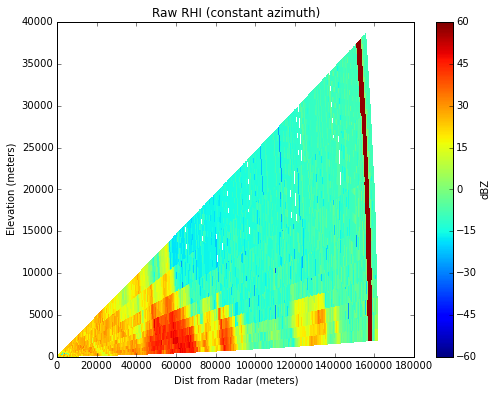

In [7]:
# creating a meshgrid with the values at the edges
azg2,rng2 = np.meshgrid(azr_e,r_e)
elg2,rng2 = np.meshgrid(elr_e,r_e)
print 'meshgrids shape:', elg2.shape, azg2.shape, rng2.shape

#slicing reflectivity for constant azimuth
dBZs = dBZ[si].T
print dBZs.shape

# converting to ECEF coordinates
X2,Y2,Z2 = rad.toECEF(rng2.flatten(),azg2.flatten(),elg2.flatten()) # Use degrees
print 'ECEF flattened shape:', X2.shape, Y2.shape, Z2.shape

# map projection from ECEF coords
mpx2,mpy2,mpz2 = proj.fromECEF(X2,Y2,Z2)
a2 = np.reshape(mpx2,azg2.shape) #range
b2 = np.reshape(mpy2,azg2.shape) #azimuth
c2 = np.reshape(mpz2,azg2.shape) #elevation
print 'updated shape to match:', a2.shape, b2.shape, c2.shape

# plotting
plt.figure(figsize=(8,6))
plt.pcolormesh(np.sqrt(b2**2+a2**2),c2,dBZs,vmin=-60,vmax=60) #magnitude 
plt.title('Raw RHI (constant azimuth)')
plt.ylabel('Elevation (meters)')
plt.xlabel('Dist from Radar (meters)')
plt.colorbar(label='dBZ')

## Number 2

In [8]:
# restarting analysis for the grid centers for the interpolations

# creating a meshgrid
azg2,rng2 = np.meshgrid(azr,r)
elg2,rng2 = np.meshgrid(elr,r)
print 'meshgrids shape:', elg2.shape, azg2.shape, rng2.shape

# to ECEF
X2,Y2,Z2 = rad.toECEF(rng2.flatten(),azg2.flatten(),elg2.flatten()) # Use degrees
print 'ECEF flattened shape:', X2.shape, Y2.shape, Z2.shape

# map projection
mpx2,mpy2,mpz2 = proj.fromECEF(X2,Y2,Z2)
a2 = np.reshape(mpx2,azg2.shape) #range
b2 = np.reshape(mpy2,azg2.shape) #azimuth
c2 = np.reshape(mpz2,azg2.shape) #elevation
print 'updated shape to match:', a2.shape, b2.shape, c2.shape

meshgrids shape: (996, 9) (996, 9) (996, 9)
ECEF flattened shape: (8964,) (8964,) (8964,)
updated shape to match: (996, 9) (996, 9) (996, 9)


### Linear Interpolation

In [9]:
from matplotlib.mlab import griddata
# setting the data into a 250m grid (xi,yi) sized by the azimuth (works for elevation too)
xi = np.arange(a.flatten().min(),a.flatten().max(),250.)
yi = np.arange(a.flatten().min(),a.flatten().max(),250.)

### PPI

In [10]:
# for ppi let's slice, so it doesn't break the internet
a_sm = a[0:200,100:135]
b_sm = b[0:200,100:135]
dn_sm = dn[0:200,100:135]

<matplotlib.colorbar.Colorbar instance at 0x10f131128>

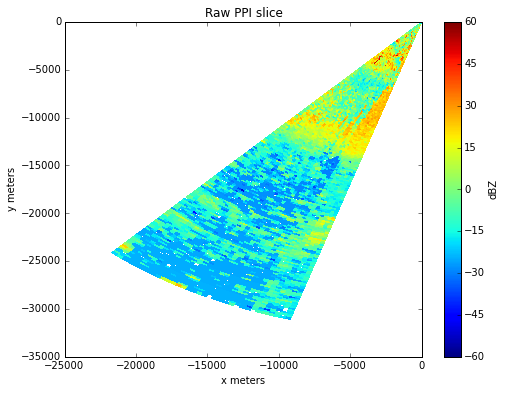

In [11]:
# plotting raw ppi slice for reference for comparison to interpolations
plt.figure(figsize=(8,6))
plt.pcolormesh(a_sm,b_sm,dn_sm,vmin=-60,vmax=60)
plt.title('Raw PPI slice')
plt.ylabel('y meters')
plt.xlabel('x meters')
plt.colorbar(label='dBZ')

In [12]:
# performing the linear interpolation on the slice from above
dlin = griddata(a_sm.flatten(),b_sm.flatten(),dn_sm.flatten(),xi,yi,interp='linear')

/Users/TTUatmo/anaconda/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


<matplotlib.colorbar.Colorbar instance at 0x10ad66a28>

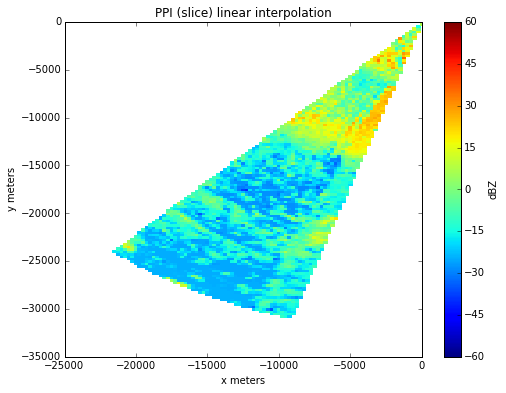

In [13]:
# plotting the slice PPI linear interpolation
plt.figure(figsize=(8,6))
plt.pcolormesh(xi,yi,dlin,vmin=-60,vmax=60)
plt.xlim(-25000,0)
plt.ylim(-35000,0)
plt.title('PPI (slice) linear interpolation')
plt.ylabel('y meters')
plt.xlabel('x meters')
plt.colorbar(label='dBZ')

### RHI

In [14]:
# instead of the normal 250m grid, using the magnitudes
xi_rhi = np.arange(np.sqrt(a2**2+b2**2).min(),np.sqrt(a2**2+b2**2).max(),250) # magnitude of the range
yi_rhi = np.arange(c2.min(),c2.max(),250)
dlin2 = griddata(np.sqrt(a2**2+b2**2).flatten(),c2.flatten(),dBZs.flatten(),xi_rhi,yi_rhi,interp='linear')

<matplotlib.colorbar.Colorbar instance at 0x11157f560>

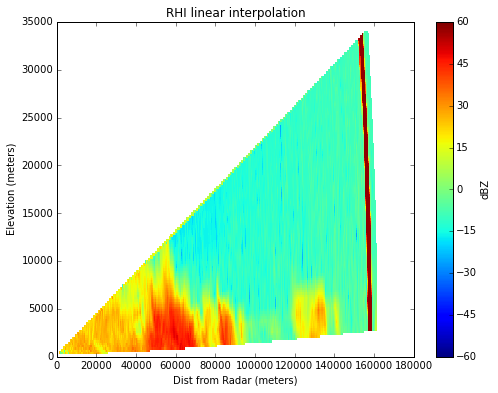

In [15]:
# plotting
plt.figure(figsize=(8,6))
plt.pcolormesh(xi_rhi,yi_rhi,dlin2,vmin=-60,vmax=60)
plt.title('RHI linear interpolation')
plt.ylabel('Elevation (meters)')
plt.xlabel('Dist from Radar (meters)')
plt.colorbar(label='dBZ')

### Natural Neighbor

### PPI

In [16]:
# using same slices as before to not break the internet
dnn = griddata(a_sm.flatten(),b_sm.flatten(),dn_sm.flatten(),xi,yi,interp='nn')

<matplotlib.colorbar.Colorbar instance at 0x10aae1a28>

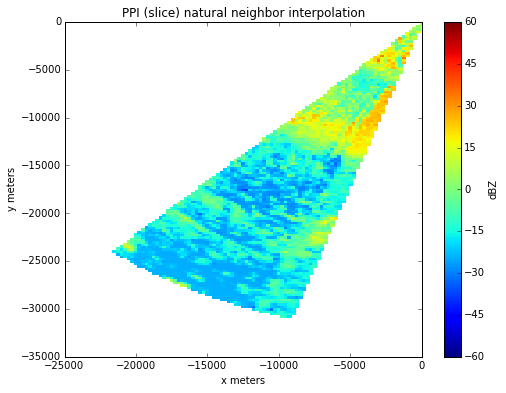

In [17]:
# plotting
plt.figure(figsize=(8,6))
plt.pcolormesh(xi,yi,dnn,vmin=-60,vmax=60)
plt.xlim(-25000,0)
plt.ylim(-35000,0)
plt.title('PPI (slice) natural neighbor interpolation')
plt.ylabel('y meters')
plt.xlabel('x meters')
plt.colorbar(label='dBZ')

### RHI

In [18]:
# perform the natural neighbor interpolation using magnitudes
dnn2 = griddata(np.sqrt(a2**2+b2**2).flatten(),c2.flatten(),dBZs.flatten(),xi_rhi,yi_rhi,interp='nn')

<matplotlib.colorbar.Colorbar instance at 0x10f3e7368>

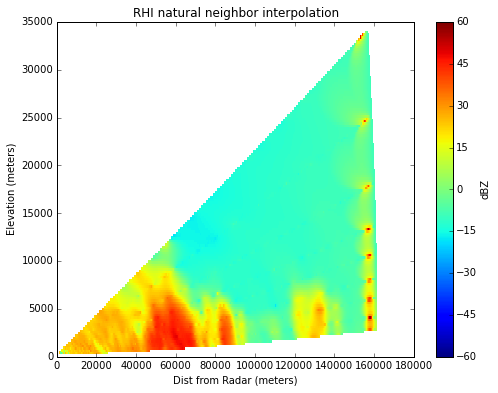

In [19]:
# plotting
plt.figure(figsize=(8,6))
plt.pcolormesh(xi_rhi,yi_rhi,dnn2,vmin=-60,vmax=60)
plt.title('RHI natural neighbor interpolation')
plt.ylabel('Elevation (meters)')
plt.xlabel('Dist from Radar (meters)')
plt.colorbar(label='dBZ')

## Connecting observations to algorithms

#### 
Linear interpolation is a weighted average between the known obvervational data points. This explains why the linearly interpolated PPI and RHI plots are smooth (without gaps in the data - "white spots") compared to the raw plots. In the raw RHI plot especially, there are obvious signs of linear averaging. Within the area of near-zero dBZ in the RHI raw data, there are various streaks of negative dBZ in various elevations. These features remain in the linear interpolation of the RHI (although slightly less negative) as the algoithm averages through the data between elevations. In the linearly interpolated PPI plot, there is more consistancy and less cellular structure in appearance compared to the raw PPI. 
    
The natural neighbor interpolation algorithm adds points in between observations, stealing area from the closeby neighboring observational data points. This interpolation is continuous and differentiable except at the data points themselves. Natural neighbor displays the data even more smoothly because it takes information from its neighbors on all sides, rather than in the linear direction. Each reflectivity value is still incorporated into the calculation of the next point along the radial change, but with the exception of the areas in which there are observation data points themselves. In the natural neighbor RHI plot, the near-zero dBZ area does not contain any erroneous streaks of negative dBZ because data points are averaged with a greater number of neighbors than the linear interpolation, obtaining the main trend. These neighbors are along the radials, but also at varying distances from the radar (range). The inability of the algorithm to interpolate at the exact data points is noticed on the outer edge of the range where there are points of high reflectivity remaining at the data points. The PPI slice has the smoothest features due to this interpolation and its effectiveness at placing new data points where necessary, incorporating the surrounding values. 